In [1]:
# Import könyvtárak
import os
import json
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import math
from tqdm.auto import tqdm
import sys

In [2]:
def load_split_csv(processed_dir: str):
    """Load train/val/test CSVs from processed_dir. Returns (train, val, test)."""
    train_path = os.path.join(processed_dir, "train.csv")
    val_path = os.path.join(processed_dir, "val.csv")
    test_path = os.path.join(processed_dir, "test.csv")

    if not os.path.exists(train_path):
        single_path = os.path.join(processed_dir, "processed_data.csv")
        if os.path.exists(single_path):
            df = pd.read_csv(single_path)
            return df, None, None
        raise FileNotFoundError(f"Missing training data in {processed_dir}")

    train_df = pd.read_csv(train_path)
    val_df = pd.read_csv(val_path) if os.path.exists(val_path) else None
    test_df = pd.read_csv(test_path) if os.path.exists(test_path) else None
    return train_df, val_df, test_df

In [3]:
def plot_confusion_matrix(y_true, y_pred, labels, save_path, split_name='Test'):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=labels, yticklabels=labels,
           ylabel='True label', xlabel='Predicted label',
           title=f'Confusion Matrix ({split_name})')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    thresh = cm.max() / 2.0 if cm.size else 0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    fig.savefig(save_path, bbox_inches='tight')
    plt.show()
    plt.close(fig)

In [4]:
def label_to_numeric(labels):
    numeric = []
    for label in labels:
        s = str(label).strip()
        if s and s[0].isdigit():
            numeric.append(int(s[0]))
        else:
            try:
                numeric.append(int(s))
            except ValueError:
                numeric.append(0)
    return np.array(numeric)

In [5]:
class BaselineTransformerDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=320):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])
        enc = self.tokenizer(text,
                             add_special_tokens=True,
                             max_length=self.max_length,
                             padding='max_length',
                             truncation=True,
                             return_tensors='pt')
        return {
            'input_ids': enc['input_ids'].squeeze(0),
            'attention_mask': enc['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [6]:
def create_label_mapping(labels):
    unique = sorted(list(set(labels)), key=lambda x: int(str(x)[0]) if str(x)[0].isdigit() else x)
    label2id = {lab: idx for idx, lab in enumerate(unique)}
    id2label = {idx: lab for lab, idx in label2id.items()}
    return label2id, id2label

In [7]:
def train_one_epoch(model, dataloader, optimizer, scheduler, device, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    disable_tqdm = not sys.stdout.isatty()
    for batch in tqdm(dataloader, desc="Train", disable=disable_tqdm):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        if scheduler:
            scheduler.step()
        running_loss += loss.item() * input_ids.size(0)
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return running_loss / max(1, total), correct / max(1, total)

In [8]:
@torch.no_grad()
def evaluate(model, dataloader, device, criterion, id2label):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_trues = []
    disable_tqdm = not sys.stdout.isatty()
    for batch in tqdm(dataloader, desc="Eval", disable=disable_tqdm):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = criterion(logits, labels)
        running_loss += loss.item() * input_ids.size(0)
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_preds.extend([id2label[int(p)] for p in preds.cpu().numpy()])
        all_trues.extend([id2label[int(t)] for t in labels.cpu().numpy()])
    avg_loss = running_loss / max(1, total)
    acc = correct / max(1, total)
    return avg_loss, acc, all_preds, all_trues

In [9]:
def _plot_overfitting_convergence(losses, accuracies, final_iteration, reports_dir):
    """Plot Loss and Accuracy curves for overfitting test convergence."""
    iterations = range(1, len(losses) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss plot
    ax1.plot(iterations, losses, linewidth=2, color='#e74c3c', alpha=0.8)
    ax1.axhline(y=0.001, color='green', linestyle='--', linewidth=2, label='Target (loss < 0.001)', alpha=0.7)
    ax1.set_xlabel('Iteration', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
    ax1.set_title('Overfitting Test: Loss Convergence', fontsize=13, fontweight='bold')
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.legend(fontsize=11)
    ax1.set_yscale('log')
    
    # Accuracy plot
    ax2.plot(iterations, accuracies, linewidth=2, color='#27ae60', alpha=0.8)
    ax2.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Target (acc = 100%)', alpha=0.7)
    ax2.set_xlabel('Iteration', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax2.set_title('Overfitting Test: Accuracy Convergence', fontsize=13, fontweight='bold')
    ax2.set_ylim([0, 1.1])
    ax2.grid(True, alpha=0.3, linestyle='--')
    ax2.legend(fontsize=11)
    
    fig.tight_layout()
    
    save_path = os.path.join(reports_dir, '03-baseline_overfitting_test_convergence.png')
    fig.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    plt.close(fig)
    
    print(f"Saved overfitting test convergence plot to {save_path}")

In [10]:
def overfitting_test(model, tokenizer, device, X_data, y_data_ids, label2id, id2label, max_length=320, max_iterations=1000, reports_dir='../output/reports'):
    """Overfitting test: train on a single batch (32 samples) until 100% accuracy and loss < 0.001."""
    print("\n" + "="*80)
    print("OVERFITTING TEST: Training on single batch (32 samples)")
    print("Target: 100% accuracy and loss < 0.001")
    print("="*80)
    
    # Take only first 32 samples
    test_batch_size = min(32, len(X_data))
    X_test = X_data[:test_batch_size]
    y_test = y_data_ids[:test_batch_size]
    
    print(f"Batch size: {test_batch_size}")
    print(f"Unique labels in batch: {set(y_test)}")
    
    # Create dataset
    test_ds = BaselineTransformerDataset(X_test, y_test, tokenizer, max_length=max_length)
    test_loader = DataLoader(test_ds, batch_size=test_batch_size, shuffle=False, num_workers=0)
    
    # Disable regularization
    for module in model.modules():
        if isinstance(module, nn.Dropout):
            module.p = 0.0
    
    # Optimizer with NO weight decay
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.0)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.0)
    
    model.train()
    iteration = 0
    best_loss = float('inf')
    
    # Track metrics for visualization
    history_losses = []
    history_accuracies = []
    
    while iteration < max_iterations:
        iteration += 1
        
        for batch in test_loader:
            optimizer.zero_grad()
            
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = criterion(logits, labels)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Calculate accuracy
            preds = torch.argmax(logits, dim=1)
            accuracy = (preds == labels).sum().item() / len(labels)
            
            # Store metrics for plotting
            history_losses.append(loss.item())
            history_accuracies.append(accuracy)
            
            if iteration % 50 == 0 or iteration == 1:
                print(f"Iteration {iteration:4d} | Loss: {loss.item():.6f} | Accuracy: {accuracy:.4f} ({int(accuracy*100)}%)")
            
            # Check success criteria
            if loss.item() < 0.001 and accuracy == 1.0:
                print("\n" + "="*80)
                print("SUCCESS! Overfitting test passed!")
                print(f"Final Loss: {loss.item():.8f} | Final Accuracy: {accuracy:.4f} (100%)")
                print(f"Converged in {iteration} iterations")
                print("="*80 + "\n")
                
                # Plot convergence curve
                _plot_overfitting_convergence(history_losses, history_accuracies, iteration, reports_dir)
                
                return True
            
            # Check for improvement
            if loss.item() < best_loss:
                best_loss = loss.item()
    
    # If we reach here, test failed
    print("\n" + "="*80)
    print("FAILURE! Overfitting test did NOT converge to 100% accuracy + loss < 0.001")
    print(f"Reached iteration {iteration} without meeting criteria")
    print(f"Best loss achieved: {best_loss:.6f}")
    print("="*80)
    
    raise RuntimeError("OVERFITTING TEST FAILED")

## Model Training & Overfitting Test

In [11]:
# Configuration
base_output = os.getenv('OUTPUT_DIR', '../output')
processed_dir = os.path.join(base_output, 'processed')
models_dir = os.path.join(base_output, 'models')
reports_dir = os.path.join(base_output, 'reports')

Path(models_dir).mkdir(parents=True, exist_ok=True)
Path(reports_dir).mkdir(parents=True, exist_ok=True)

print(f"Processed data dir: {processed_dir}")

Processed data dir: /app/output/processed


In [12]:
# Load data
train_df, val_df, test_df = load_split_csv(processed_dir)
if 'text' not in train_df.columns or 'label' not in train_df.columns:
    raise ValueError("Train CSV must contain 'text' and 'label'")

X_train = train_df['text'].astype(str).tolist()
y_train = train_df['label'].astype(str).tolist()

print(f"Training samples: {len(X_train)}")
display(train_df.head())

Training samples: 2100


,text,label,word_count,avg_word_len
0,a regisztráció eredményeként a rossmann létreh...,4-Érthető,58,7.120690
1,"arról, hogy az adott településen vagy települé...",4-Érthető,111,6.909910
2,"3/12. vatera fenntartja a jogot, hogy bizonyos...",4-Érthető,45,7.044444
3,a vállalkozó a szerződés teljesítése során tud...,1-Nagyon nehezen érthető,92,7.315217
4,3/5. a felhasználónak a vaterán tett ajánlatai...,4-Érthető,10,8.000000


In [13]:
# Label mapping
label2id, id2label = create_label_mapping(y_train)
mapping_path = os.path.join(models_dir, 'baseline_label_mapping.json')
with open(mapping_path, 'w', encoding='utf-8') as f:
    json.dump({'label2id': label2id, 'id2label': {str(k): v for k, v in id2label.items()}}, f, ensure_ascii=False, indent=2)
print(f"Saved baseline label mapping to {mapping_path}")

y_train_ids = [label2id[l] for l in y_train]

Saved baseline label mapping to /app/output/models/baseline_label_mapping.json


In [14]:
# Hyperparameters
model_name = os.getenv('BASELINE_TRANSFORMER_MODEL', os.getenv('TRANSFORMER_MODEL', 'SZTAKI-HLT/hubert-base-cc'))
batch_size = int(os.getenv('BATCH_SIZE', '8'))
max_length = int(os.getenv('BASELINE_MAX_LENGTH', os.getenv('MAX_LENGTH', '320')))

print(f"Baseline Transformer: {model_name}")
print(f"Batch size: {batch_size}")
print(f"Max length: {max_length}")

Baseline Transformer: SZTAKI-HLT/hubert-base-cc
Batch size: 8
Max length: 320


In [15]:
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [16]:
# Load model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label2id))
model.to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model Architecture: {total_params:,} total | {trainable_params:,} trainable parameters")

tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/420 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at SZTAKI-HLT/hubert-base-cc and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model Architecture: 110,621,957 total | 110,621,957 trainable parameters



BASELINE MODEL: Overfitting Test Mode

OVERFITTING TEST: Training on single batch (32 samples)
Target: 100% accuracy and loss < 0.001
Batch size: 32
Unique labels in batch: {0, 1, 2, 3, 4}
Iteration    1 | Loss: 1.628837 | Accuracy: 0.2812 (28%)
Iteration   50 | Loss: 0.001970 | Accuracy: 1.0000 (100%)

SUCCESS! Overfitting test passed!
Final Loss: 0.00099586 | Final Accuracy: 1.0000 (100%)
Converged in 95 iterations



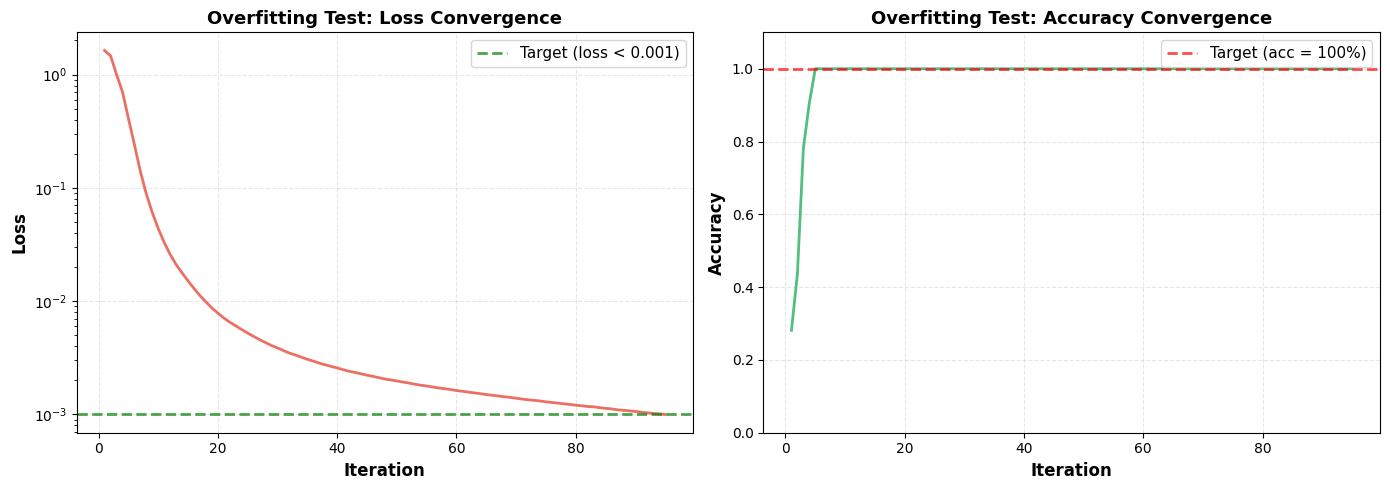

Saved overfitting test convergence plot to /app/output/reports/03-baseline_overfitting_test_convergence.png
Overfitting test PASSED! Model validated successfully.



In [17]:
# RUN OVERFITTING TEST
print("\n" + "="*80)
print("BASELINE MODEL: Overfitting Test Mode")
print("="*80)

overfitting_test(model, tokenizer, device, X_train, y_train_ids, label2id, id2label, max_length=max_length, reports_dir=reports_dir)
print("Overfitting test PASSED! Model validated successfully.\n")

In [18]:
# Save baseline transformer model after successful overfitting test
baseline_model_dir = os.path.join(models_dir, 'baseline_transformer_model')
Path(baseline_model_dir).mkdir(parents=True, exist_ok=True)
model.save_pretrained(baseline_model_dir)
tokenizer.save_pretrained(baseline_model_dir)
print(f"Model saved to {baseline_model_dir}")

Model saved to /app/output/models/baseline_transformer_model
